##### Copyright 2019 The TensorFlow Authors.

# 합성곱 신경망

### MNIST 숫자를 분류하기 위한 CNN 모델

코랩(Colab)에서 이 노트북을 실행한다면 * 수정 -> 노트 설정 -> 하드웨어 가속기* 에서 GPU를 선택하세요.

### 텐서플로 임포트하기

In [41]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

### MNIST 데이터셋 다운로드하고 준비하기

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print('Train: X=%s, y=%s' % (train_images.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_images.shape, test_labels.shape))

Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


<AxesSubplot:ylabel='count'>

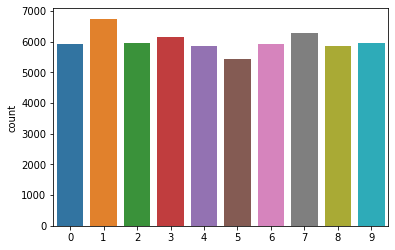

In [42]:
sns.countplot(train_labels)

<AxesSubplot:ylabel='count'>

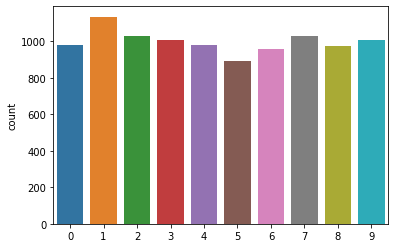

In [43]:
sns.countplot(test_labels)

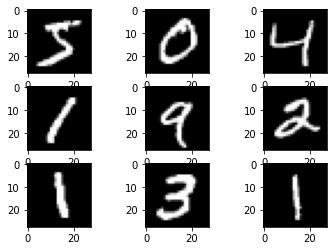

In [22]:
import matplotlib.pyplot as plt

# 9개의 샘플 그려보기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
plt.show()

In [23]:
# 픽셀 값을 0~1 사이로 정규화합니다.
train_images, test_images = train_images / 255.0, test_images / 255.0

### 합성곱 신경망 만들기 : Conv2D + MaxPooling2D

[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
[MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

- CNN 입력: 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받음
- 예시에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하는 CNN을 정의함. 이 값을 첫 번째 층의 `input_shape` 매개변수로 전달
- MNIST 데이터는 흑백 이미지이기 때문에 컬러 채널(channel)이 하나
- (참고) 컬러 이미지는 (R,G,B) 세 개의 채널로 구성되어 있음 

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(10, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(20, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### 모델 구조 출력

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 20)          0         
Total params: 5,280
Trainable params: 5,280
Non-trainable params: 0
_________________________________________________________________


- 위 모델 구조에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서
- 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가짐
- Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됨(예를 들면, 32 또는 64)
- 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있음.

### 숫자 분류를 위해 마지막에 Dense 층 추가하기

- 숫자 분류 문제를 해결하기 위해 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입
- Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서임. 따라서 3D 출력을 1D로 펼쳐야함
- 그다음 하나 이상의 Dense 층을 그 위에 추가
- MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용함

In [33]:
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

### 최종 모델 구조 출력

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               32100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

여기에서 볼 수 있듯이 두 개의 Dense 층을 통과하기 전에 (4, 4, 64) 출력을 (1024) 크기의 벡터로 펼쳤습니다.

### 모델 컴파일과 훈련하기

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3274 - accuracy: 0.8985
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0477 - accuracy: 0.9857
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0306 - accuracy: 0.9903
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0227 - accuracy: 0.9929
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0173 - accuracy: 0.9938


### 모델 평가

In [29]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.0277 - accuracy: 0.9917


In [30]:
print(test_acc)

0.9916999936103821


결과에서 보듯이 간단한 CNN 모델이 99%의 테스트 정확도를 달성합니다. 몇 라인의 코드치고 나쁘지 않네요! (케라스의 서브클래싱 API와 GradientTape를 사용하여) CNN을 만드는 또 다른 방법은 [여기](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/quickstart/advanced.ipynb)를 참고하세요.